In [1]:
import json
import requests
import pandas as pd
import seaborn as sb
from datetime import datetime

In [2]:
entitlement_token = 'cecc4267a0194af89ca343805a3e57af'

In [223]:
class MacdTradeSimulator:
  def __init__(
      self,
      symbol,
      start_date=None,
      end_date=None,
      time_frame='P1Y',
      allow_next_day_trades=True,
      **kwargs
    ):
    self.entitlement_token = 'cecc4267a0194af89ca343805a3e57af'
    self.base_headers = {
      'Origin': 'https://www.marketwatch.com',
      'Referer': 'https://www.marketwatch.com',
      'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:85.0) Gecko/20100101 Firefox/85.0'
    }
    self.allow_next_day_trades = allow_next_day_trades
    self.time_frame = time_frame
    self.symbol_info = self.__get_symbol_info(symbol)
    self.start_date = self.__get_milliseconds_from_datetime(start_date)
    self.end_date = self.__get_milliseconds_from_datetime(end_date) - 31536000000
    self.price, self.macd, self.macd_minus_signal = self.__get_price_and_macd()
    self.results = None

  def __get_milliseconds_from_datetime(self, dt):
    if not dt:
      return int(datetime.now().timestamp() * 1000)
    return int(dt.timestamp() * 1000)

  def __get_symbol_info(self, symbol):
    cleaned_symbol = symbol.strip().lower()
    url = 'https://api.wsj.net/api/autocomplete/search'
    headers = {
      'Host': 'api.wsj.net'
    }
    params = {
      'entitlementToken': self.entitlement_token,
      'q': cleaned_symbol,
      't': 'symbol',
      'style': 'full',
      'maxRows': 1,
      'name_startsWith': cleaned_symbol
    }
    r = requests.get(url, params=params, headers={**headers, **self.base_headers})
    if r.status_code != 200:
      raise Exception(f'Request failed: {r.reason}')
    r_json = r.json()
    symbols = r_json.get('symbols')
    if not symbols or len(symbols) == 0:
      raise Exception(f'Could not get information for symbol: {symbol}')
    best_guess = symbols[0]
    return best_guess

  def __get_price_and_macd(self):
    if not self.symbol_info:
      raise Exception(f'Could not get data because symbol info is missing')
    key = self.symbol_info['chartingSymbol']
    json_param = {
      'EntitlementToken': self.entitlement_token,
      'FilterClosedPoints': True,
      'FilterNullSlots': False,
      'IncludeClosedSlots': False,
      'IncludeCurrentQuotes': False,
      'IncludeMockTick': True,
      'IncludeOfficialClose': True,
      'InjectOpen': False,
      'ResetTodaysAfterHoursPercentChange': False,
      'Series': [{'DataTypes': ['Last'],
        'Dialect': 'Charting',
        'Indicators': [{'Kind': 'MovingAverageConvergenceDivergence',
          'Parameters': [{'Name': 'EMA1', 'Value': 12},
            {'Name': 'EMA2', 'Value': 26},
            {'Name': 'SignalLine', 'Value': 9}],
          'SeriesId': 'i4'}],
        'Key': key,
        'Kind': 'Ticker',
        'SeriesId': 's1'}],
      'ShowAfterHours': False,
      'ShowPreMarket': False,
      'Step': 'P1D',
      'TimeFrame': self.time_frame,
      'UseExtendedTimeFrame': True,
      'WantPriorClose': False
    }
    url = 'https://api-secure.wsj.net/api/michelangelo/timeseries/history'
    headers = {
      'Host': 'api-secure.wsj.net',
      'Dylan2010.EntitlementToken': self.entitlement_token,
    }
    params = {
      'json': json.dumps(json_param),
      'ckey': self.entitlement_token[:10]
    }
    r = requests.get(url, params=params, headers={**headers, **self.base_headers})
    if r.status_code != 200:
      raise Exception(f'Request failed: {r.reason}')
    r_json = r.json()
    if not r_json.get('Series'):
      raise Exception('Response data did not contain "Series" property')
    price_series, macd_series = r_json['Series']
    if not price_series.get('DataPoints') or not macd_series.get('DataPoints'):
      raise Exception('Response data did not contain "DataPoints" property')
    price = [i[0] for i in price_series['DataPoints']]
    macd_tuples = macd_series['DataPoints']
    macd = [i[0] for i in macd_tuples]
    macd_minus_signal = [i[1] for i in macd_tuples]
    return price, macd, macd_minus_signal

  def get_theoretical_max_profit(self):
    if not self.price:
        return 0
    max_profit = 0
    min_price = self.price[0]
    for i in range(1, len(self.price)):
        if self.price[i] < min_price:
            min_price = self.price[i]
        max_profit = max(max_profit, self.price[i] - min_price)
    return max_profit

  def get_hold_profit(self):
    if not self.price:
        return 0
    return self.price[-1] - self.price[0]

  def get_results_df(self):
    if not self.results:
      return None
    df = pd.DataFrame(self.results)
    df.index = df['day']
    df.drop('day', axis=1, inplace=True)
    return df

  def simulate(self):
    # Reset results on object
    self.results = []
    days = range(1, len(self.price))

    state = {
      'last_trade_day': 0,
      'is_stock_owned': False,
      'last_buy_price': 0,
      'total_profit': 0
    }

    def buy(state, day_result):
      if not self.allow_next_day_trades and day_result['day'] - state['last_trade_day'] < 2:
        return
      if not state['is_stock_owned']:
        state['is_stock_owned'] = True
        state['last_buy_price'] = day_result['price']
        state['last_trade_day'] = day_result['day']
        day_result['action'] = 'buy'

    def sell(state, day_result):
      if not self.allow_next_day_trades and day_result['day'] - state['last_trade_day'] < 2:
        return
      if state['is_stock_owned']:
        profit_from_sale = day_result['price'] - state['last_buy_price']
        state['is_stock_owned'] = False
        state['last_trade_day'] = day_result['day']
        state['total_profit'] += profit_from_sale
        day_result['action'] = 'sell'
        day_result['profit'] = profit_from_sale

    for day in days:
      result = {
        'day': day,
        'price': self.price[day],
        'macd': self.macd[day],
        'macd_minus_signal': self.macd_minus_signal[day],
        'macd_diff': self.macd[day] - self.macd_minus_signal[day],
        'macd_diff_prev': self.macd[day - 1] - self.macd_minus_signal[day - 1],
        'macd_sign_change': None,
        'macd_flipped': False,
        'action': None,
        'profit': 0,
      }

      result['macd_sign_change'] = result['macd_diff'] * result['macd_diff_prev']

      # Flipped
      if result['macd_sign_change'] < 0:
        result['macd_flipped'] = True
        # Buy signal
        if result['macd_diff'] > 0:
          buy(state, result)
        else:
          sell(state, result)
      elif result['macd_sign_change'] == 0:
        result['macd_flipped'] = True
        # Check whether macd was on top the previous day
        if result['macd_diff_prev'] > 0:
          sell(state, result)
        else:
          buy(state, result)
      else:
        result['action'] = 'hold' if state['is_stock_owned'] else None

      result['total_profit'] = state['total_profit']
      self.results.append(result)

In [224]:
sim = MacdTradeSimulator(
    'BRK.A',
    time_frame='P1Y',
    allow_next_day_trades=True
)

In [225]:
sim.simulate()

In [226]:
sim.get_hold_profit(), sim.get_theoretical_max_profit()

(13501.0, 114760.0)

In [227]:
results_df = sim.get_results_df()
results_df
# results_df[results_df['macd_sign_change'] < 0]

,price,macd,macd_minus_signal,macd_diff,macd_diff_prev,macd_sign_change,macd_flipped,action,profit,total_profit
day,,,,,,,,,,
1,340361.0,607.229884,667.538097,-60.308213,-54.425314,3.282293e+03,False,None,0.0,0.0
2,340780.0,617.312772,657.493032,-40.180260,-60.308213,2.423200e+03,False,None,0.0,0.0
3,341000.0,635.727424,653.139911,-17.412486,-40.180260,6.996382e+02,False,None,0.0,0.0
4,338500.0,443.479902,611.207909,-167.728007,-17.412486,2.920562e+03,False,None,0.0,0.0
5,340223.9,425.323811,574.031089,-148.707279,-167.728007,2.494238e+04,False,None,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
247,346175.0,991.390881,2128.006174,-1136.615293,-1146.782955,1.303451e+06,False,None,0.0,57537.0
248,350201.0,1086.593851,1919.723709,-833.129859,-1136.615293,9.469481e+05,False,None,0.0,57537.0
249,350701.0,1188.686276,1773.516223,-584.829947,-833.129859,4.872393e+05,False,None,0.0,57537.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd233a24470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd233a24470>)

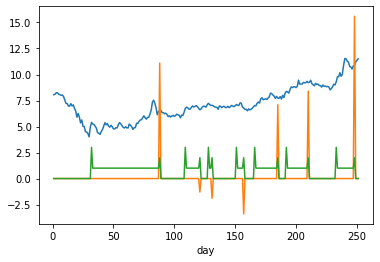

In [189]:
results_df['price'].plot(), results_df['profit'].apply(lambda x: x * 10).plot(), results_df['action'].apply(lambda x: {None: 0, 'hold': 1, 'sell': 2, 'buy': 3}[x]).plot()

In [205]:
test_symbols =  "AAPL,MSFT,AMZN,GOOGL,TSLA,FB,BABA,TSM,BRK.A,V,JNJ,JPM,WMT,MA,NVDA,DIS,PG,PYPL,UNH,HD,BAC,NFLX,PDD,INTC,ADBE,CMCSA,ASML,VZ,NKE,ABT,CRM,KO,XOM,TM,T,NVS,CSCO,TMO,PEP,PFE,LLY,ABBV,MRK,AVGO,ORCL,CVX,ACN,DHR,QCOM,NEE".split(',')

In [232]:
test_results = []

for symbol in test_symbols:
  try:
    sim = MacdTradeSimulator(
      symbol,
      time_frame='P5Y'
    )
    sim.simulate()
    test_result = {
      'symbol': symbol
    }
    test_result['hold_profit'] = sim.get_hold_profit()
    test_result['theoretical_max_profit'] = sim.get_theoretical_max_profit()
    test_result['algorithm_profit'] = sim.results[-1]['total_profit']
    test_results.append(test_result)
  except Exception as e:
    print(e)
    continue

test_df = pd.DataFrame(test_results)
test_df.index = test_df['symbol']
test_df.drop('symbol', axis=1, inplace=True)

unsupported operand type(s) for -: 'NoneType' and 'NoneType'


In [233]:
test_df['algorithm_performance'] = test_df['algorithm_profit'] - test_df['hold_profit']
test_df

,hold_profit,theoretical_max_profit,algorithm_profit,algorithm_performance
symbol,,,,
AAPL,113.007500,120.575000,78.085000,-34.922500
MSFT,192.790000,194.570000,38.680000,-154.110000
AMZN,2864.050000,3049.380000,807.110000,-2056.940000
GOOGL,1384.670000,1407.690000,686.480000,-698.190000
TSLA,822.632000,854.356000,540.808018,-281.823981
FB,168.350000,204.370000,65.540000,-102.810000
BABA,204.570000,256.570000,-53.900000,-258.470000
TSM,104.980000,112.160000,73.280000,-31.700000
BRK.A,163146.000000,164760.000000,126282.100000,-36863.900000
